# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Буду разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Открытие файла с данными и изучение общей информации

Мой основной инструмент — `pandas`. Я подключаю эту библиотеку. Также подключаю библиотеки `re`, `numpy`, `pymystem3` и `collections` - они понадобятся для моих исследований.

In [1]:
import pandas as pd                # импорт библиотеки pandas
import re                          # импорт библиотеки регулярных выражений re
import numpy as np                 # импорт библиотеки numpy
from pymystem3 import Mystem       # импорт модуля pymystem3
from collections import Counter    # импорт модуля collections

Далее осуществляю чтение файла `data.csv` из папки `/datasets` и сохраняю его в переменной `data`. Вывожу на экран первые десять строк таблицы и получаю общую информацию о таблице, с которой мне предстоит работать.

In [2]:
# чтение файла с данными и сохранение в data в зависимости от его расположения
try:
    data = pd.read_csv('C:/Users/datasets/data.csv') # локальный путь
except:
    data = pd.read_csv('/datasets/data.csv')         # серверный путь

display(data.head(10)) # получение первых 10 строк таблицы data
print()
print('Общая нформация об исходной таблице данных:')
print()
data.info() # получение общей информации о данных в таблице data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи



Общая нформация об исходной таблице данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Итак, в таблице 12 столбцов. Тип данных в столбцах — `object`, `float`, `int`.

Согласно документации к данным:
* `children` — количество детей в семье;
* `days_employed` — общий трудовой стаж в днях;  
* `dob_years` — возраст клиента в годах;
* `education` — уровень образования клиента;
* `education_id` — идентификатор уровня образования;
* `family_status` — семейное положение;
* `family_status_id` — идентификатор семейного положения;
* `gender` — пол клиента;
* `income_type` — тип занятости;
* `debt` — имел ли задолженность по возврату кредитов;
* `total_income` — ежемесячный доход;
* `purpose` — цель получения кредита.

В названиях колонок не обнаружены нарушения стиля, однако количество значений в столбцах различается. Значит, в данных есть пропущенные значения, требующие дополнительной предобработки.
Также бросаются в глаза отрицательные значения в столбцах, где отрицательных значений быть не должно, а еще нет единообразия регистра и огромное число знаков после запятой. На этапе предобработки данных все эти проблемы будут решены!

## Шаг 2. Предобработка данных

### Обработка пропусков

Определяю, в каких колонках исследуемой таблицы обнаружены пропуски:

In [3]:
print(data.isna().sum()) # выявление колонок, содержащих пропуски

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


Проверю гипотезу о том, что пропуски в трудовом стаже и типе занятости соответствуют друг другу. Напишу проверку, которая состоит в следующем: создаются дополнительные столбцы, содержащие булевы значения True, если ячейка заполнена и False - если пуста для столбцов `days_employed` и `total_income`. Далее создаю столбец `compare` с булевыми значениями True в случае, если в обоих столбцах пусто (или оба заполнены) и False, если в одном пусто, а в другом есть значение. Считаю количество строк, в которых не совпадает пусто/не пусто. 

In [4]:
# создание столбца с булевыми значениями есть пропуск или его нет в столбце
data['days_employed_mis'] = data['days_employed'].isna()
data['total_income_mis'] = data['total_income'].isna()
data['compare'] = data['days_employed_mis'] == data['total_income_mis']
# сравнение значений е двух столбцах
#if len(data[data['compare'] == False]) == 0:
#    print('Полное соответствие')
#else:
#    print('Не соответствуют')

# новая проверка! получение строк, в которых есть пропуски в столбце days_employed и их подсчет
# подсчет в этой выборке пропусков в столбце total_income
# если значения равны, то полное соответствие

days_employed_nan = len(data[data['days_employed'].isna()])
total_income_nan = data[data['days_employed'].isna()]['total_income'].isna().count()
if days_employed_nan == total_income_nan:
    print('Полное соответствие')
else:
    print('Не соответствуют')

Полное соответствие


Проверка показала, что пропуски в трудовом стаже и типе занятости полностью соответствуют друг другу.

Т.к. обе колонки имеют тип `float`, то значение NaN, принадлежащее к данному типу, замещает отсутствующее в ячейке число и с ним можно проводить математические операции. Посчитаю долю пропущенных значений.

In [5]:
days_employed_nan = len(data[data['days_employed'].isna()]) # подсчет пропущенных значений
print('Доля пропущенных значений составила {:.1%}'.format(days_employed_nan / len(data)))
#  подсчет доли пропущенных значений

Доля пропущенных значений составила 10.1%


В 2174 строках из 21525 (около 10% от всего объема информации) значения общего трудового стажа и ежемесячного дохода пропущены. Серьезное значение, при чем пропуски в доходах и трудовом стаже соответствуют друг другу, поэтому можно предположить, что здесь есть определенная закономерность. Попробую определить закономерность появления пропусков. Зависит ли их появление от семейного положения или от типа занятости. Чтобы понимать, какими значениями заполнять эти пропуски.

Для этого выделю `Series` с отсутствующими значениями и применю группировку сначала по семейному положению, а потом по типу занятости для подсчета доли пропущенных значений в получившихся группах.

In [6]:
print('Проверка гипотезы о зависимости появления пропусков от семейного положения:')
# группировка по столбцу и подсчет доли пропусков в этой группе
print(round(data.groupby('family_status')['days_employed_mis'].mean(), 2).sort_values(ascending=False))
print()
print('Проверка гипотезы о зависимости появления пропусков от типа занятости:')
print(round(data.groupby('income_type')['days_employed_mis'].mean(), 2).sort_values(ascending=False))

Проверка гипотезы о зависимости появления пропусков от семейного положения:
family_status
гражданский брак         0.11
женат / замужем          0.10
вдовец / вдова           0.10
Не женат / не замужем    0.10
в разводе                0.09
Name: days_employed_mis, dtype: float64

Проверка гипотезы о зависимости появления пропусков от типа занятости:
income_type
предприниматель    0.50
пенсионер          0.11
сотрудник          0.10
компаньон          0.10
госслужащий        0.10
студент            0.00
в декрете          0.00
безработный        0.00
Name: days_employed_mis, dtype: float64


Из полученных таблиц видно, что распределение долей пропущенных значений в группах по семейному положению более или менее равномерно. Однако в таблице, где показана зависимость количества пропусков от типа занятости, можно заметить следующее: для половины предпринимателей не указаны значения стажа и ежемесячного дохода.

Пропуски нельзя оставлять без внимания: группировка данных со значением NaN может привести к некорректным результатам анализа. 
На практике было бы правильно установить причину пропусков и восстановить данные. Но пока такой возможности нет, поэтому в целях сохранения параметров распределения заполняемых переменных, я буду заполнять пропуски медианным значением `median()` с группировкой по одной переменной, а именно по типу занятости (`income_type`), т.к. не была установлена зависимость от семейного положения.

In [7]:
print('Трудовой стаж (в зависимости от типа занятости) заполняется следующими значениями:')
for income_type in data['income_type'].unique():
    median_days = data.loc[data['income_type'] == income_type, 'days_employed'].median()
    print(income_type, median_days)
    data.loc[(data['days_employed'].isna()) & (data['income_type'] == income_type), 'days_employed'] = median_days
print()  
print('Ежемесячный доход (в зависимости от типа занятости) заполняется следующими значениями:')
# перебор значений в колонке 'children' в цикле и замена пропущенных значений медианными значениями
# в зависимости от количества детей в семье
for income_type in data['income_type'].unique():    
    median_income = data.loc[data['income_type'] == income_type, 'total_income'].median()
    print(income_type, median_income)
    data.loc[(data['total_income'].isna()) & (data['income_type'] == income_type), 'total_income'] = median_income

# повторный подсчет пропущенных значений
days_employed_nan = len(data[data['days_employed'].isna()])
total_income_nan = len(data[data['total_income'].isna()])

print()
print('После выполнения замены значений:')
print('Значение трудового стажа пропущено', len(data[data['days_employed'].isna()]), 'раз')
print('Значение ежемесячного дохода пропущено', len(data[data['total_income'].isna()]), 'раз')  

Трудовой стаж (в зависимости от типа занятости) заполняется следующими значениями:
сотрудник -1574.2028211070851
пенсионер 365213.30626573117
компаньон -1547.3822226779334
госслужащий -2689.3683533043886
безработный 366413.65274420456
предприниматель -520.8480834953765
студент -578.7515535382181
в декрете -3296.7599620220594

Ежемесячный доход (в зависимости от типа занятости) заполняется следующими значениями:
сотрудник 142594.39684740017
пенсионер 118514.48641164352
компаньон 172357.95096577113
госслужащий 150447.9352830068
безработный 131339.7516762103
предприниматель 499163.1449470857
студент 98201.62531401133
в декрете 53829.13072905995

После выполнения замены значений:
Значение трудового стажа пропущено 0 раз
Значение ежемесячного дохода пропущено 0 раз


Удаляю вспомогательные столбцы из датафрейма и провожу дополнительную проверку, что в таблице не осталось пропусков. Для этого ещё раз подсчитываю пропущенные значения по колонкам.

In [8]:
# удаление вспомогательных столбцов
data = data.drop(['days_employed_mis', 'total_income_mis', 'compare'], axis = 1)
# повторный подсчёт пропусков после выполнения замены значений (вернет нули при успешной замене)
print(data.isna().sum())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


**Вывод**

Итак, в 2174 строках из 21525 (около 10% от всего объема исследуемых данных) обнаружены пропуски в количественных переменных значений общего трудового стажа и ежемесячного дохода. В связи с отсутствием возможности восстановления этих данных, пропуски заполнены медианным значением с группировкой в зависимости от типа занятости клиента.
Пропуски в категориальных переменных не обнаружены.

### Обработка некорректных значений

Для числовых переменных я оценю среднее, минимальное и максимальное значения, чтобы установить, в каком диапазоне лежат данные. Для этого воспользуюсь методом `describe()` из библиотеки регулярных выражений `re`. Процентиль в данном случае не оценивается, поэтому список `percentiles` оставлю пустым. В список `include` я не буду включать категориальные переменные, а оставлю только `float` и `int`. Для наглядности округлю значения в таблице методом `round`.

In [9]:
include = ['float', 'int'] # какие типы включить
perc = [] # какие процентили включить

# сведения о значениях в столбце
display(round(data.describe(percentiles = perc, include = include))) 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.0,21525.0,21525.0,21525.0,21525.0,21525.0,21525.0
mean,1.0,63550.0,43.0,1.0,1.0,0.0,165225.0
std,1.0,141150.0,13.0,1.0,1.0,0.0,98044.0
min,-1.0,-18389.0,0.0,0.0,0.0,0.0,20667.0
50%,0.0,-1356.0,42.0,1.0,0.0,0.0,142594.0
max,20.0,401755.0,75.0,4.0,4.0,1.0,2265604.0


Вызывают вопросы следующие столбцы:
* children:
    * наличие отрицательных значений количества детей;
    * максимальное количество детей равно 20;
* days_employed:
    * наличие отрицательных значений трудового стажа;
    * максимальное значение трудового стажа составляет около 1100 лет;
* dob_years:
    * минимальный возраст клиента равен нулю.

#### Обработка столбца 'children'

Вывожу на экран список уникальных значений столбца `children`. Для этого:
* извлекаю нужный столбец датафрейма, 
* вызываю метод `value_counts( )`, который посчитает количество уникальных значений.

In [10]:
print(data['children'].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


Теперь посчитаю долю некорректных значений (20 и -1) в столбце и попытаюсь оценить, повлияет ли это количество на результаты исследования.

In [11]:
error_1 = data[data['children'] == 20]['children'].count() # Подсчет некорректных значений
error_2 = data[data['children'] == -1]['children'].count()

print('Процент некорректных значений в столбце "children" составляет {:.1%}'.format((error_1 + error_2) / len(data)))

Процент некорректных значений в столбце "children" составляет 0.6%


Можно сделать предположение, что -1 - это нет детей (0), а цифры 2 и 0 находятся на клавиатуре рядом и поэтому в столбце с завидным постоянством появляется число 20. Доля этих значений составляет чуть более полпроцента (незначительное количество).
Проведу дополнительное исследование, в каких случаях встречаются такие значения, и на основании этого буду решать, чем заполнять. 

In [12]:
print('Распределение значений 20 детей:')
display(data.loc[data['children'] == 20]['family_status'].value_counts())
print('Распределение значений -1 детей:')
display(data.loc[data['children'] == -1]['family_status'].value_counts())

Распределение значений 20 детей:


женат / замужем          49
гражданский брак         12
Не женат / не замужем     9
вдовец / вдова            4
в разводе                 2
Name: family_status, dtype: int64

Распределение значений -1 детей:


женат / замужем          29
Не женат / не замужем     5
гражданский брак          5
в разводе                 4
вдовец / вдова            4
Name: family_status, dtype: int64

Все строки будут сохранены и некорректные значения будут заменены следующим образом: -1 будут заменено но 1, а для значения -20 - на 2, т.к. некорректные значения встречаются чаще у клиентов, состоящих в браке, поэтому делаею предположение, что и -1 и 20 - это опечатки и по логике заменяю все некорректные значения на 1 и 2 соответственно. Проверяю, не встречается ли некорректные значения и пишу дополнительную проверку, не потерялись ли строки.

In [13]:
data['children'] = data['children'].replace(-1, 1) # замена в столбце значения -1 на 1
data['children'] = data['children'].replace(20, 2) # замена в столбце значения 20 на 2

print(data['children'].value_counts()) # вывод количества уникальных значений в столбце
print()
if len(data['children']) == len(data):
    print('Ничего не потерялось, строк в таблице -', len(data))
else:
    print('Внимание, потеряно', len(data) - len(data['children']), 'строк!')

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Ничего не потерялось, строк в таблице - 21525


Теперь значения количества детей в таблице вопросов не вызывает.

#### Обработка столбца 'days_employed'

Т.к. в столбце обнаружены отрицательные значения, посчитаю долю этих значений, чтобы принять решение, как с ними поступить. Исключить ли строки с некорректными значениями из фрейма или обработать.

In [14]:
# подсчет значений меньше 0
negative_days = data.loc[data['days_employed'] < 0]['days_employed'].count()
print('Отрицательный стаж составляет {:.1%}'.format(negative_days / len(data)))

Отрицательный стаж составляет 82.1%


Т.к. процент отрицательных значений критически высок, а данные выгружались из нескольких систем, делаю предположение, что формат выгрузки одного из источника был такой, что автоматически сформировались отрицательные значения. Принимаю решение заменить отрицательные значения положительными функцией `abs()` и провожу проверку.

In [15]:
data['days_employed'] = data['days_employed'].apply(abs) # все значения в столбце по модулю
# повторный подсчет значений меньше 0
print('Итого отрицательных значений стажа после замены -', data.loc[data['days_employed'] < 0]['days_employed'].count())

Итого отрицательных значений стажа после замены - 0


Далее проверю распределение значений по оси, чтобы понять, каким образом сформированы аномально высокие значения, а именно 1100 лет. Чтобы построить график, использую метод `hist()` из библиотеки numpy.

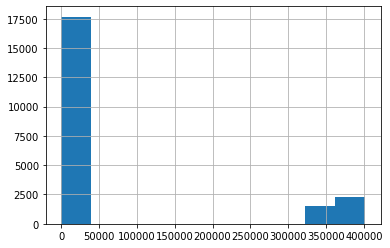

In [16]:
data['days_employed'].hist() # построение гистограммы

In [17]:
# подсчет количества строк со значениями более 300000
error_days = data.loc[data['days_employed'] > 300000]['days_employed'].count()
print()
print('Аномально большое количество дней стажа составляет {:.1%}'.format(error_days / len(data)))


Аномально большое количество дней стажа составляет 17.9%


Из гистограммы распределения величины видно, что почти 18% значений находятся в диапазоне от 350000 до 400000. Делаю предположение, что эти данные указаны не в днях, а в часах. Проверю правильность своей гипотезы, заменив значения на дни и снова выведу гистограмму.

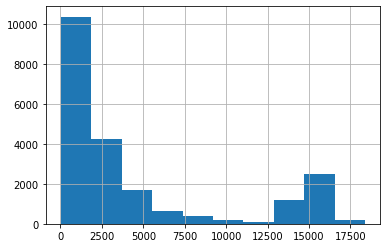

In [18]:
# проверка по условию - все значения больше 300000 перевести из часов в дни (разделить на 24)
data.loc[data['days_employed'] > 300000, 'days_employed'] = data.loc[data['days_employed'] > 300000, 'days_employed'] / 24
data['days_employed'].hist() # построение гистограммы

In [19]:
# сведения по значениям в столбцу
display(round(data['days_employed'].describe(percentiles = perc, include = include))) 

count    21525.0
mean      4601.0
std       5354.0
min         24.0
50%       1994.0
max      18389.0
Name: days_employed, dtype: float64

После корректировки значения трудового стажа колеблются от 0 до 49 лет и вопросов более не вызывают.

#### Обработка столбца 'dob_years'

Проверю количество уникальных значений в столбце, чтобы попробовать определить долю некорректных значений.

In [20]:
print(data['dob_years'].unique()) # вывод уникальных значений в столбце
# подсчет количества строк, где возраст равен 0
age_error = data.loc[data['dob_years'] == 0]['dob_years'].count()
print('Не указан возраст в {:.1%} случаев'.format(age_error / len(data)))

[42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
Не указан возраст в 0.5% случаев


Т.к. процент пропуска значений возраста невелик (всего полпроцента) и теоретически на результат решения задачи не повлияет, заменю нулевые значения медианным `median()` с группировкой по одной переменной, а именно по типу занятости `(income_type)`. Провожу проверку совершенной замены.

In [21]:
print('Возраст клиента (в зависимости от типа занятости) заполняется следующими значениями:')
for income_type in data['income_type'].unique():
    median_age = data.loc[data['income_type'] == income_type, 'dob_years'].median()
    print(income_type, round(median_age))
    data.loc[(data['dob_years'] == 0) & (data['income_type'] == income_type), 'dob_years'] = median_age
print()
print('Итого нулевых значений возраста после замены -', data.loc[data['dob_years'] == 0]['dob_years'].count())

Возраст клиента (в зависимости от типа занятости) заполняется следующими значениями:
сотрудник 39
пенсионер 60
компаньон 39
госслужащий 40
безработный 38
предприниматель 42
студент 22
в декрете 39

Итого нулевых значений возраста после замены - 0


Повторно выведу информацию о колонке со значениями возрастов клиентов:

In [22]:
# сведения по значениям в столбце
print(round(data['dob_years'].describe(percentiles = perc, include = include)))

count    21525.0
mean        43.0
std         12.0
min         19.0
50%         43.0
max         75.0
Name: dob_years, dtype: float64


Проведу дополнительную проверку, есть ли в исследуемом датафрейме строки, в которых значение трудового стажа превышает возраст клиента. Т.к. трудовой стаж указан в днях, а возраст в годах - приведу сравниваемые величины к единой метрике, умножив возраст на 365. Выведу на экран эти величины:

In [23]:
error_dob_years = data[data['dob_years'] * 365 <= data['days_employed']]
print('Количество несоответствий возраста трудовому стажу -', len(error_dob_years))
print('{:.2%} от общего числа записей'.format((len(error_dob_years)) / len(data)))

Количество несоответствий возраста трудовому стажу - 62
0.29% от общего числа записей


Чуть больше четверти процента приходится на некорректные строки, в которых трудовой стаж превышает возраст. На мой взгляд целесообразно исключить эти строки из датафрейма, т.к. это определенно ошибки ввода данных и однозначно нельзя сказать, какое из значений было внесено некорректно.

In [24]:
data = data.loc[data['dob_years'] * 365 > data['days_employed']]

Провожу дополнительную проверку, не осталось ли в данных некорректных строк по указанному параметру:

In [25]:
error_dob_years = data[data['dob_years'] * 365 <= data['days_employed']]
print('Количество несоответствий возраста трудовому стажу -', len(error_dob_years))

Количество несоответствий возраста трудовому стажу - 0


### Замена типа данных

В исследуемой таблице общий трудовой стаж (столбец `days_employed`) и ежемесячный доход (столбец `total_income`) представлены вещественными значениями. Для удобства выполнения операций со столбцами сразу переведу значения в этих столбцах в целочиленные методом `astype()` и проверю полученный результат методом `dtypes`.

In [26]:
print('Исходный тип данных в столбце days_employed -', data['days_employed'].dtypes)
print('Исходный тип данных в столбце total_income -', data['total_income'].dtypes)
data['days_employed'] = data['days_employed'].astype('int') # изменение типа данных
data['total_income'] = data['total_income'].astype('int')
print()
print('Тип данных в столбце days_employed -', data['days_employed'].dtypes) # вывод типа данных
print('Тип данных в столбце total_income -', data['total_income'].dtypes)

Исходный тип данных в столбце days_employed - float64
Исходный тип данных в столбце total_income - float64

Тип данных в столбце days_employed - int64
Тип данных в столбце total_income - int64


**Вывод**

Целочисленные значения в колонках *общий трудовой стаж* и *ежемесячный доход* - это удобно, т.к. копейки в ежемесячном доходе и неполный день в трудовом стаже - незначительные доли, которые не повлияют на реультаты исследования, поэтому вещественные значения были переведены в целочисленные.

**Вывод**

В результате анализа выявлены некорректные значения в столбцах:
* количество детей (`children`):
    * наличие отрицательных значений количества детей;
    * максимальное количество детей равно 20;
* трудовой стаж (`days_employed`):
    * наличие отрицательных значений трудового стажа;
    * максимальное значение трудового стажа составляет около 1100 лет;
* возраст клиента (`dob_years`):
    * минимальный возраст клиента равен нулю.
    
Проведена обработка всех некорректных значений со следующими результатами:
* отрицательных значений количества детей не встречается;
* более 5 детей в таблице не встречается;
* отрицательные значения трудового стажа не встречаются;
* максимальное значение трудового стажа составляет 49 лет;
* минимальный возраст клиента равен 19.

### Обработка дубликатов

Применю метод `value_counts` к столбцу `education` для выявления неявных дубликатов.

In [27]:
print(data['education'].value_counts()) # подчсет количества уникальных значений в столбце 

среднее                13706
высшее                  4709
СРЕДНЕЕ                  771
Среднее                  707
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   267
начальное                248
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64


Бросаются в глаза одинаковые названия, но написанные в разных регистрах. Это может затруднить категоризацию, поэтому необходимо привести все значения к одному регистру (нижнему) методом `str.lower()`. Cнова проверить содрежимое столбца `education`.

In [28]:
data['education'] = data['education'].str.lower() # применение нижнего регистра в столбце
print(data['education'].value_counts()) # подчсет количества уникальных значений в столбце

среднее                15184
высшее                  5249
неоконченное высшее      744
начальное                280
ученая степень             6
Name: education, dtype: int64


Теперь другое дело, вопросов к содержанию колонки `education` нет! Проделаю то же самое со столбцами, содержащими категориальные переменные `family_status` и `income_type`, после чего можно приступать к удалению явных дубликатов.

In [29]:
data['family_status'] = data['family_status'].str.lower()
data['income_type'] = data['income_type'].str.lower()

Осуществляю подсчет явных дубликатов в таблице методом `duplicated()`. Если дупликаты выявлены, то удалю явные дубликаты методом `drop_duplicates` с удалением старых индексов и формированием новых. Далее проверю таблицу на отсутствие дубликатов после удаления.

In [30]:
dupls = data.duplicated().sum() # подсчет дубликатов в датафрейме
if dupls > 0:
    print('В данных обнаружено', dupls, 'явных дубликатов')
    print('Производится удаление дубликатов...')
    data = data.drop_duplicates().reset_index(drop = True) # удаление дубликатов с обновлением индексов
    print()
    print('После удаления количество явных дубликатов составляет -', data.duplicated().sum())
else:
    print('Дубликатов не найдено')

print('Количество строк в таблице -', len(data))
#data.info()

В данных обнаружено 71 явных дубликатов
Производится удаление дубликатов...

После удаления количество явных дубликатов составляет - 0
Количество строк в таблице - 21392


Основные причины возникновения дубликатов — повторные представления, неправильное соединение данных из разных источников, ошибки пользователя при занесении информации. В нашем случае точно известно, что данные в таблицу собирались из нескольких систем, поэтому скорее всего - это и послужило причиной появления дубликатов.

**Вывод**

В результате проведенного анализа проведена проверка категориальных переменных на неявные дубликаты (данные приведены к единому регистру) и просле проверки выявлены явные дубликаты (полное соответствие строк), которые в количестве 71 штуки исключены из датафрейма.

### Лемматизация

Лемматизацию (приведение слова к его словарной форме - лемме) буду проводить с использованием библиотек с функцией лемматизации на русском языке, а именно — pymystem3. Выделю уникальные значения в столбце цели получения кредита - `purpose`, также для подсчета числа их упоминаний в таблице использую специальный контейнер `Counter` из модуля `collections`, отсортирую по убыванию методом `most_common`.

In [31]:
print(data['purpose'].unique()) # для дополнительной информации

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'ремонт жилью' 'заняться высшим образованием']


In [32]:
m = Mystem()
data_lemmas = m.lemmatize(' '.join(data['purpose']))
display(Counter(data_lemmas).most_common()) # подсчет упоминаний в датафрейме и сортировка

[(' ', 54882),
 ('недвижимость', 6338),
 ('покупка', 5887),
 ('жилье', 4449),
 ('автомобиль', 4297),
 ('образование', 3999),
 ('с', 2910),
 ('операция', 2597),
 ('свадьба', 2309),
 ('свой', 2226),
 ('на', 2218),
 ('строительство', 1876),
 ('высокий', 1368),
 ('коммерческий', 1307),
 ('получение', 1307),
 ('для', 1286),
 ('жилой', 1229),
 ('сделка', 939),
 ('дополнительный', 904),
 ('заниматься', 900),
 ('подержать', 854),
 ('проведение', 765),
 ('сыграть', 761),
 ('сдача', 648),
 ('семья', 638),
 ('собственный', 635),
 ('со', 626),
 ('ремонт', 605),
 ('приобретение', 460),
 ('профильный', 435),
 ('подержанный', 110),
 ('\n', 1)]

Выделю из получившегося списка наиболее часто встречающиеся существительные для образования категорий и напишу функцию, которая будет лемматизировать последовательно каждую ячейку столбца `purpose` и проверять, какая из категорий обнаруживается в лемматизированном варианте и записывать в столбец `purpose_category`.

In [33]:
# определение категории в соответствии с полученной леммой
def categorize(purpose):
    purpose_lemmas = m.lemmatize(purpose)
    if 'недвижимость' in purpose_lemmas or 'жилье' in purpose_lemmas:
        return 'недвижимость'
    if 'автомобиль' in purpose_lemmas:
        return 'автомобиль'
    if 'образование' in purpose_lemmas:
        return 'образование'
    if 'свадьба' in purpose_lemmas:
        return 'свадьба'
    return 'другое' 

data['purpose_category'] = data['purpose'].apply(categorize) # запись категории в столбец

print('Количество записей в категориях:')
print(data['purpose_category'].value_counts())
print()
print('Доля в % от всех записей:')
print(round(data['purpose_category'].value_counts() / len(data) * 100))

Количество записей в категориях:
недвижимость    10787
автомобиль       4297
образование      3999
свадьба          2309
Name: purpose_category, dtype: int64

Доля в % от всех записей:
недвижимость    50.0
автомобиль      20.0
образование     19.0
свадьба         11.0
Name: purpose_category, dtype: float64


**Вывод**

Проведена лемматизация столбца `цель получения кредита` таким образом, что обнаружены 4 основные категории, в которые было распределено 100% данных, что подтверждено отсутствием записей в категории 'другое'.
Также установлено, что половина всех кредитов берется на покупку/ремонт/строительство жилья, примерно одинаково по 20% от общего числа тратится на все, что связано с автомобилями и образованием, а остальные 10% берут кредиты на организацию свадебного торжества.

### Категоризация данных

Задача стоит выяснить влияет ли
- семейное положение
- количество детей клиента
- уровень дохода
- цели кредита
на факт погашения кредита в срок.

Цели кредита у меня уже выделены в категории на предыдущем этапе, категорий в значениях семейное положение и количества детей и так немного - все достаточно конкретно, теперь необходимо выделить категории по уровню дохода. Прибегну к категоризации — объединению избранных данных в произвольные группы по заданному критерию. Для этого выделю 3 категории уровня дохода: низкий, средний и высокий. Проверю значения медианы и выделю пороги для категорий:

In [34]:
income_median = (data['total_income'].median())
print(income_median)

142594.0


В моем исследовании ранее пропущенные значения в столбце `уровень дохода` были заполнены медианными значениями, поэтому некорректно было бы выбирать такой порог. Исходя из здравого смысла буду считать за высокий уровень дохода доход выше медианного значение по столбцу, а низкий уровень - ниже половины этого значения. Все остальное отнесу к среднему уровню дохода. Помещу полученные категории в дополнительный столбец `income_category`.

In [35]:
# определение категории в соответствии с уровнем дохода
def categorize(total_income):
    if total_income > income_median:
        return 'высокий доход'
    if total_income < income_median / 2:
        return 'низкий доход'
    return 'средний доход' 

data['income_category'] = data['total_income'].apply(categorize) # запись категории дохода в столбец

print('Количество записей в категориях:')
print(data['income_category'].value_counts())
print()
print('Доля в % от всех записей:')
print(round(data['income_category'].value_counts() / len(data) * 100))

Количество записей в категориях:
высокий доход    10589
средний доход     9232
низкий доход      1571
Name: income_category, dtype: int64

Доля в % от всех записей:
высокий доход    49.0
средний доход    43.0
низкий доход      7.0
Name: income_category, dtype: float64


In [36]:
display(data[['total_income', 'income_category']].head(5)) # проверка заполнения столбца категорий
#data.info()

,total_income,income_category
0,253875,высокий доход
1,112080,средний доход
2,145885,высокий доход
3,267628,высокий доход
4,158616,высокий доход


Также на всякий случай я проведу категоризацию по количству детей. Разобью данные на 2 группы - клиент имеет детей и не имеет, запишу данные в отдельный столбец `children_category`:

In [37]:
# определение категории в соответствии с наличием детей
def categorize(children):
    if children == 0:
        return 'нет детей'
    return 'есть дети' 

data['children_category'] = data['children'].apply(categorize) # запись категории в столбец

print('Количество записей в категориях:')
print(data['children_category'].value_counts())
print()
print('Доля в % от всех записей:')
print(round(data['children_category'].value_counts() / len(data) * 100))

Количество записей в категориях:
нет детей    14047
есть дети     7345
Name: children_category, dtype: int64

Доля в % от всех записей:
нет детей    66.0
есть дети    34.0
Name: children_category, dtype: float64


**Вывод**

В результате проведенной категоризации по уровню дохода выделены 3 категории: высокий доход, средний и низкий. Можно увидеть, что половина клентов банка, берущих кредит, имеют высокий уровень дохода, тогда как клиенты с низким уровнем дохода, составляют всего 7% от всех оформляющих кредит. Также проведена категоризация по наличию детей у клиента. Можно заметить, что тех, кто берет кредит, имея детей, в 2 раза меньше, чем тех, у кого детей нет. Теперь можно пробовать анализировать данные по поставленным вопросам.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для определения зависимости между наличием детей и возвратом кредита в срок, необходимо сгруппировать данные по выделенным категориям есть/нет детей и обратиться к столбцу `debt` — имел ли клиент задолженность по возврату кредитов, где 0 - не имел задолженностей, а 1 - была задолженность. Рассчитать общее количество клиентов в этой группе (`count()`), количество должников в этой категории (сумму единиц в этой группе - `sum()`) и долю должников в этой группе (сумма единиц на общее число в группе `mean()`) 

In [38]:
print()
print('Определение зависимости между наличием детей и возвратом кредита в срок')
report_children = data.groupby('children_category').agg({'debt': ['count', 'sum', 'mean']})
report_children.columns = ['Кол-во клиентов', 'Кол-во должников', 'Доля должников']
display(report_children.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))


Определение зависимости между наличием детей и возвратом кредита в срок


,Кол-во клиентов,Кол-во должников,Доля должников
children_category,,,
есть дети,7345,673,9.16%
нет детей,14047,1059,7.54%


Для дополнительной информации сгруппирую данные по количеству детей и рассчитаю те же самые величины, построив для проверки дополнительную сводную таблицу:

In [39]:
print()
print('Определение зависимости между количеством детей и возвратом кредита в срок')
#report_children_count = data.groupby('children').agg({'debt': ['count', 'sum', 'mean']})
#report_children_count.columns = ['Кол-во клиентов', 'Кол-во должников', 'Доля должников']
#display(report_children_count.sort_values(by='Доля должников', ascending=False))
#display(report_children_count.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))
#print()

report_children_pivot = data.pivot_table(index='children', columns='debt', values='income_type', aggfunc='count')
report_children_pivot.columns = ['Нет должников', 'Есть должники']
report_children_pivot['Доля должников'] = report_children_pivot['Есть должники'] / (report_children_pivot['Нет должников'] + report_children_pivot['Есть должники'])
report_children_pivot = report_children_pivot.fillna(0)
display(report_children_pivot.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))


Определение зависимости между количеством детей и возвратом кредита в срок


,Нет должников,Есть должники,Доля должников
children,,,
4,37,4,9.76%
2,1922,200,9.43%
1,4402,442,9.12%
3,302,27,8.21%
0,12988,1059,7.54%
5,9,0,0.00%


**Вывод**

Из полученных таблиц можно сделать следующий вывод: должников среди тех клиентов, у которых детей нет - меньше, чем у клиентов с детьми (только что те клиенты, у которых пятеро детей, вообще ни разу не задолжали банку, но выборка слишком мала для обоснования вывода о том, что клиенты с 5 детьми никогда не имеют задолженностей, их в представленных данных - всего 9 человек и не является показательным случаем) и действительно - разница в результирующих долях по возврату кредитов не велика и не превышает 3%, явных перекосов не наблюдается, однако в любом случае процент клиентов, которые имели просрочку по кредиту, без детей меньше, чем "должников" с детьми.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Для определения зависимости между семейным положением и возвратом кредита в срок, необходимо сгруппировать данные по столбцу `семейное положение`:

In [40]:
print()
print('Определение зависимости между семейным положением и возвратом кредита в срок')
#report_family = data.groupby('family_status').agg({'debt': ['count', 'sum', 'mean']})
#report_family.columns = ['Кол-во клиентов', 'Кол-во должников', 'Доля должников']
#display(report_family.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))

report_family_pivot = data.pivot_table(index='family_status', columns='debt', values='income_type', aggfunc='count')
report_family_pivot.columns = ['Нет должников', 'Есть должники']
report_family_pivot['Доля должников'] = report_family_pivot['Есть должники'] / (report_family_pivot['Нет должников'] + report_family_pivot['Есть должники'])
display(report_family_pivot.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))


Определение зависимости между семейным положением и возвратом кредита в срок


,Нет должников,Есть должники,Доля должников
family_status,,,
не женат / не замужем,2529,273,9.74%
гражданский брак,3743,385,9.33%
женат / замужем,11389,927,7.53%
в разводе,1104,85,7.15%
вдовец / вдова,895,62,6.48%


**Вывод**

Не наблюдается зависимости между этими величинами. Распределение величин долей должников в зависимости от семейного положения более или менее равномерно, разброс колеблется в пределах 2-4%.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для определения зависимости между уровнем дохода и возвратом кредита в срок, необходимо сгруппировать данные по столбцу `категория дохода`:

In [41]:
print()
print('Определение зависимости между уровнем дохода и возвратом кредита в срок')
#report_income = data.groupby('income_category').agg({'debt': ['count', 'sum', 'mean']})
#report_income.columns = ['Кол-во клиентов', 'Кол-во должников', 'Доля должников']
#display(report_income.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))

report_income_pivot = data.pivot_table(index='income_category', columns='debt', values='income_type', aggfunc='count')
report_income_pivot.columns = ['Нет должников', 'Есть должники']
report_income_pivot['Доля должников'] = report_income_pivot['Есть должники'] / (report_income_pivot['Нет должников'] + report_income_pivot['Есть должники'])
display(report_income_pivot.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))


Определение зависимости между уровнем дохода и возвратом кредита в срок


,Нет должников,Есть должники,Доля должников
income_category,,,
средний доход,8438,794,8.60%
высокий доход,9759,830,7.84%
низкий доход,1463,108,6.87%


**Вывод**

Из полученной таблицы можно сделать следующий вывод: клиенты с низким уровнем дохода меньше всего берут кредиты, тогда как клиенты с высоким и средним доходом берут кредиты примерно одинаково, однако на возврат кредита в срок данный уровень никак не влияет. Распределение величин долей должников по-прежнему равномерно распределено.

- Как разные цели кредита влияют на его возврат в срок?

Для ответа на данный вопрос построим распределение доли должников в группах по цели получения кредита. Для этого необходимо сгруппировать данные по столбцу `категория цели`:

In [42]:
print()
print('Как разные цели кредита влияют на его возврат в срок')
#report_purpose = data.groupby('purpose_category').agg({'debt': ['count', 'sum', 'mean']})
#report_purpose.columns = ['Кол-во клиентов', 'Кол-во должников', 'Доля должников']
#display(report_purpose.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))

report_purpose_pivot = data.pivot_table(index='purpose_category', columns='debt', values='income_type', aggfunc='count')
report_purpose_pivot.columns = ['Нет должников', 'Есть должники']
report_purpose_pivot['Доля должников'] = report_purpose_pivot['Есть должники'] / (report_purpose_pivot['Нет должников'] + report_purpose_pivot['Есть должники'])
display(report_purpose_pivot.sort_values(by='Доля должников', ascending=False).style.format({'Доля должников':'{:.2%}'}))


Как разные цели кредита влияют на его возврат в срок


,Нет должников,Есть должники,Доля должников
purpose_category,,,
автомобиль,3897,400,9.31%
образование,3632,367,9.18%
свадьба,2125,184,7.97%
недвижимость,10006,781,7.24%


**Вывод**

Из полученной таблицы можно сделать следующий вывод, что у клиентов, берущих кредит на образование и на все, что связано с автомобилями, дела с возвратом кредита в срок обстоят хуже, чем у тех клиентов, кто берет заемные средства на организацию свадебного торжества. А из всех клиентов с больше процентной вероятностью отдадут кредит в срок те, кто берет его на все, что связано с недвижимостью (покупка, ремонт, строительство и пр.).

## Шаг 4. Общий вывод

Получен файл, собранный из нескольких источников, с информацией о платежеспособности клиентов банков.

Данные из таблицы прошли полную предобработку, включающую в себя:
   * определение и заполнение пропущенных значений, появившихся скорее всего в связи с объединением данных из нескольких БД;
   * удаление дубликатов;
   * приведение данных к единообразному виду в соответствии со здравым смыслом (изменение регистра, удаление ряда знаков после запятой в колонках, где такая точность нецелесообразна);
   * исправление некорректных данных;
   * категоризацию данных в целях получения решения поставленных конкретных задач;

Что касается технической части вопроса, то тут нужно обязательно обратить внимание на качество исходных данных. Огромное количество данных прошло корректировку в процессе предварительной предобработки. Скорее всего появление ошибок, пропусков и дубликатов связано со слиянием данных в общую таблицу из нескольких источников, тогда как эти данные в различных источниках представлены в разных форматах! В одном источнике это дни, в другом - часы, формат представления трудового стажа в некоторых источниках - это отрицательные значения и пр. Перед слиянием таблиц необходима дополнительная проверка.

В результате проведенных исследований по скорректированным данным сделаны следующие выводы:
   * существует зависимость между наличием детей и возвратом кредита в срок. Вероятнее кредит без задолженностей отдаст клиент, не имеющий детей.
   * нет зависимости между семейным положением и возвратом кредита в срок.
   * также нет зависимости между уровнем дохода и возвратом кредита в срок. Однако точно выяснено, что клиенты с низким уровнем дохода берут кредиты на порядки реже, чем клиенты со средним и выскоим уровнями доходов.
   * определено, что у клиентов, берущих кредит на образование и на все, что связано с автомобилями, дела с возвратом кредита в срок обстоят хуже, чем у тех клиентов, кто берет заемные средства на организацию свадебного торжества. А из всех клиентов с больше процентной вероятностью отдадут кредит в срок те, кто берет его на все, что связано с недвижимостью (покупка, ремонт, строительство и пр.).

Из вышесказанного можно сделать общий вывод о том, что потенциальный клиент без детей с большей вероятностью будет без задолженностей платить по кредиту, особенно, если этот кредит берется на любые операции с недвижимостью. Также, если у клиента есть дети и кредит берется на образование или автомобиль, то вероятность пройти кредит без долгов не на много, но все-таки снижается. Семейное положение и уровень дохода в данном случае никак не повлияет на возврат кредита в срок.